# Convolutional neural network with Keras

In this demo, we will train and test a CNN model on the CIFAR10 dataset using Keras.

# Set the seed
For consistent results we can set the seed, although setting the seed will not cause the same results from two models with the same parameters.

In [3]:
#Random seed
import os 
import numpy as np 
import tensorflow as tf 

random_seed = 2025

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## 1. Load dataset

The following code will load the dataset into memory, and preprocess the inputs.

In [5]:
from keras.datasets import cifar10
import numpy as np

# Load the CIFAR-10 dataset
(X_train_temp, Y_train_temp), (X_test, Y_test) = cifar10.load_data()

from sklearn.model_selection import train_test_split
X_train,X_validation,Y_train,Y_validation = train_test_split(X_train_temp, Y_train_temp, test_size = 0.2, random_state=0)

# Convert pixel values data type to float32
X_train = X_train.astype('float32')  /255
X_validation = X_validation.astype('float32')  /255
X_test  = X_test.astype('float32')  /255

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

#mean2 = np.array([np.mean(X_train[:, :, :,[0]]),np.mean(X_train[:, :, :,[1]]),np.mean(X_train[:, :, :,[2]])])
#std2 = np.array([np.std(X_train[:, :, :,[0]]),np.std(X_train[:, :, :,[1]]),np.std(X_train[:, :, :,[2]])])


# Preprocessing - Standardize the data - The tiny value 1e-7 is added to prevent division by zero
# X_train= (X_train-mean)/(std+1e-7)
# X_test  = (X_test-mean) /(std+1e-7)
# X_validation = (X_validation-mean)/(std+1e-7)


# Opitional VGG-16 preprocessing - changes RGB to BGR then subtracts imagenet per pixel mean
# X_train = tf.keras.applications.vgg16.preprocess_input(X_train, data_format=None)
# X_validation = tf.keras.applications.vgg16.preprocess_input(X_validation, data_format=None)
# X_test = tf.keras.applications.vgg16.preprocess_input(X_test, data_format=None)

# Optional Changing from RGB to BGR
# X_train = X_train[:, :, :,[2, 1, 0]]
# X_test = X_test[:, :, :,[2, 1, 0]]
# X_validation = X_validation[:, :, :,[2, 1, 0]]

# Alternative preprocessing - Standardizing pixels per channel by training mean and sd per channel
# X_train = X_train[:, :, :] - mean2
# X_train = X_train[:, :, :] / std2
# X_validation = X_validation[:, :, :] - mean2
# X_validation = X_validation[:, :, :] / std2
# X_test = X_test[:, :, :] - mean2
# X_test = X_test[:, :, :] / std2


print(X_train.shape, Y_train.shape)
print(X_validation.shape, Y_validation.shape)
print(X_test.shape, Y_test.shape)


(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)
(10000, 32, 32, 3) (10000, 1)


## 2. Show a training example and its label

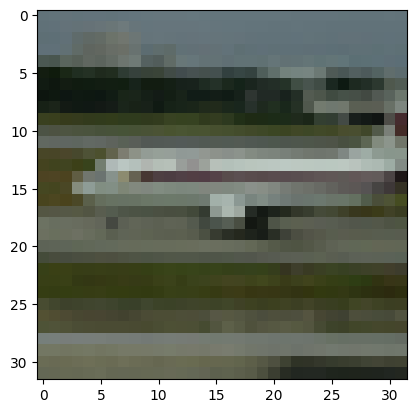

airplane


In [6]:
import matplotlib.pyplot as plt

# List of label strings for CIFAR10
label_str = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# RGB or BGR 
img_id = 4
image = X_train[img_id]
label = Y_train[img_id]

plt.imshow(image)
plt.show()
print(label_str[label[0]])

Y_train2 = Y_train #Original arrays are needed later
Y_validation2 = Y_validation
Y_test2 = Y_test

## 3. Convert label vectors into one-hot encodings
Converting into the outputs into one-hot encodings is necessasry for LeNet-5 and VGG-16, but not necessary for Resnet-50.

In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = 10
Y_train = to_categorical(Y_train, num_classes)
Y_validation = to_categorical(Y_validation, num_classes)
Y_test = to_categorical(Y_test, num_classes)

print(Y_train.shape, Y_validation.shape, Y_test.shape) #so now each label is a binary one hot encoding array - 


(40000, 10) (10000, 10) (10000, 10)


# Data Augmentation
To ensure the model generalizes well, we use data augmentation.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=15,             # Random rotations up to 15 degrees        
    width_shift_range=0.12,         # Horizontally shift up to 12% of width    
    height_shift_range=0.12,      # Vertically shift by up to 12% of height   
    horizontal_flip=True,     # Randomly flip images horiontally  
    zoom_range=0.1,           # Zoom images in by up to 10%  
    shear_range=10,             # Shear angle in counter-clockwise direction in degrees)
    channel_shift_range=0.1,      # Channel shift intensity
)


#When running the above code, we are setting up a pipeline for preprocessing the images during model training. 
#The generator applies a series of random transformations (specified by the parameters) to the images each time they are loaded into the model for training. 
#Each time an epoch is run during model training, these random transformations will create different variations of the original images. 
#These changes are made on-the-fly and don't modify our original dataset.


## 4. Define or Import the CNN model

Define the ResNet-50 model. We use the ResNet-50 architecture in tensorflow.
If we import the model, we load a model that has been trained on the specified data set. Imported models would have been saved and downloaded for consistent results.

In [10]:
#LeNet 5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters = 6, strides = (1,1), kernel_size = (5, 5), activation='tanh', input_shape=(32, 32, 3)))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2,2)))
model.add(Conv2D(filters = 6, strides = (1,1), kernel_size = (5, 5), activation='tanh'))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(120, activation = 'tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

#model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746144290.254024      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746144290.254751      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 4. Compile the model

In [12]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

# Alternative optimizer:
# sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)

# 5. Train the model

In [13]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

# Optional model training callbacks by montoring the loss on the validation set
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Optional learning rate scheduler
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr2 = LearningRateScheduler(lr_scheduler)


# Training the model
history = model.fit(data_generator.flow(X_train, Y_train, batch_size=128), 
                           epochs=100, 
                           validation_data = (X_validation, Y_validation),
                           #callbacks=[reduce_lr]
                          )

# callbacks=[reduce_lr]
# callbacks=[reduce_lr, early_stopping] # Alternative callbacks

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746144337.245246      95 service.cc:148] XLA service 0x79ed80026c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746144337.246405      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746144337.246428      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746144337.546757      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/313 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.1105 - loss: 2.3322

I0000 00:00:1746144340.047605      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.2300 - loss: 2.0797 - val_accuracy: 0.3606 - val_loss: 1.7972
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.3399 - loss: 1.8439 - val_accuracy: 0.3909 - val_loss: 1.7021
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.3626 - loss: 1.7770 - val_accuracy: 0.4169 - val_loss: 1.6495
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.3779 - loss: 1.7246 - val_accuracy: 0.4242 - val_loss: 1.6074
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.3970 - loss: 1.6770 - val_accuracy: 0.4495 - val_loss: 1.5479
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4222 - loss: 1.6226 - val_accuracy: 0.4606 - val_loss: 1.5170
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4250 - loss: 1.6013 - val_accuracy: 0.4606 - val_loss: 1.5075
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4276 - loss: 1.5922 - val_

## 1. Evaluate the trained model on test set

In [15]:
#model = resnet_model
accuracy = model.evaluate(X_test, Y_test)[1]
print(accuracy)

# 0.8799999952316284 US NN

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5853 - loss: 1.1522
0.5825999975204468


# Save the model or model weights

In [16]:
# Save the model
model.save('/kaggle/working/DA_LeNet5_100_epoch_Adam_128batchsize_Normalised.h5')
#resnet_model.save_weights('/kaggle/working/DA_ResNet50_100_epoch_Adam_128batchsizeWEIGHTS.weights.h5', overwrite=True)


# Plot the training vs validation accuracy during training

/tmp/ipykernel_31/1935870371.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legendobj in legend.legendHandles:


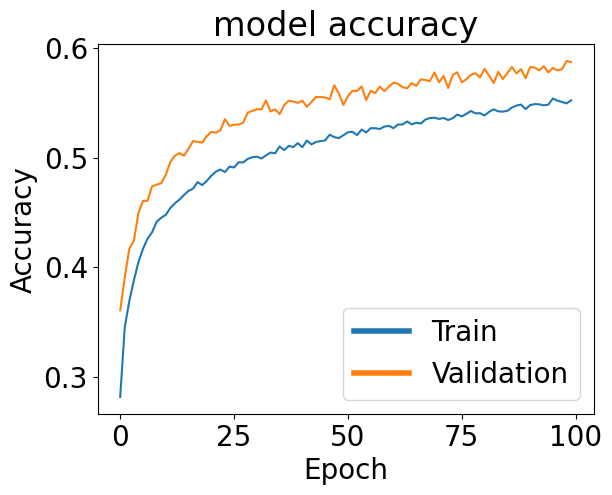

In [17]:
import matplotlib
# Change font size of plot
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


# Plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')



# Adjust Legend line thickness
legend = plt.legend(['Train', 'Validation'], loc='lower right')

for legendobj in legend.legendHandles:
    legendobj.set_linewidth(4.0)
    







plt.show()

# Plot the training vs validation accuracy during training

/tmp/ipykernel_31/1117963580.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legendobj in legend.legendHandles:


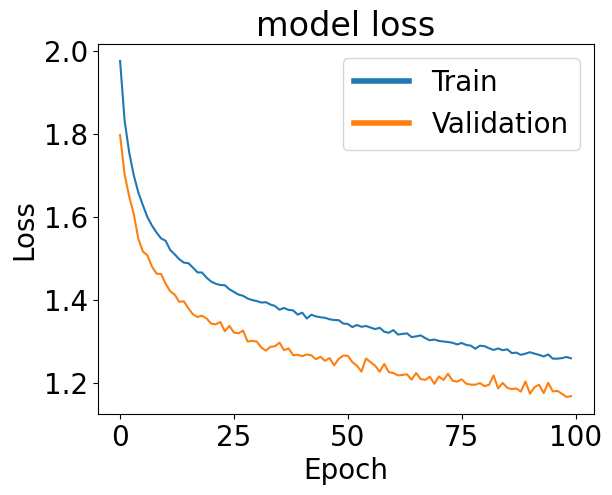

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
legend = plt.legend(['Train', 'Validation'], loc='upper right')

for legendobj in legend.legendHandles:
    legendobj.set_linewidth(4.0)

plt.show()

# Compute all model predictions
When the model creates predictions for an image, it assigns a probability for each class that the image belongs to that class. The model's prediction for an image is then the class with the highest probability for that image. This highest probability is the confidence of the model for that prediction

In [42]:
# Load all model preditions - There is a probablitly/confidence array for each validation or test sample
model = resnet_model
X_validation_preds = model.predict(X_validation)
X_test_preds = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


# Show a Test Example and the Model predicition

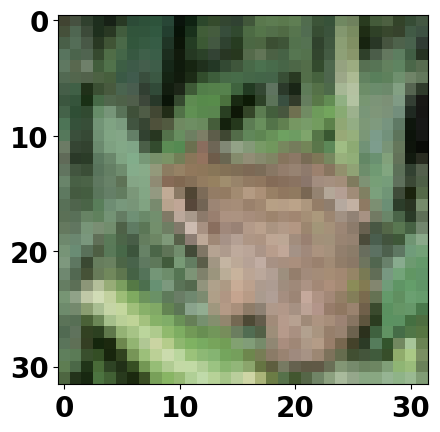

Test Index_Id:  4
True Label:  frog
Model label and associated confidence:  ['frog', 0.99182147]


In [46]:
# Printing a test image and the model prediction
test_img_id = 4
test_image1 = X_test[test_img_id]
test_label1 = Y_test2[test_img_id]

# Show image
plt.imshow(test_image1)  
plt.show()
print("Test Index_Id: ", test_img_id)
print("True Label: ", label_str[test_label1[0]])

# Model predicted label and the models confidence                 
model_predicted_label_index = ( X_test_preds[test_img_id:test_img_id+1] ).argmax()  #Essentially loading the probabilities for all classes then picking the index location of the maximum and its corresponding label
model_predicted_label_confidence = ( X_test_preds[test_img_id:test_img_id+1] ).max()
print("Model label and associated confidence: ", [label_str[model_predicted_label_index], model_predicted_label_confidence])


# Compare accuracy and average confidence
Now that we have a trained model on the dataset, we can begin to evaluate it. We begin by comparing the accuracy against the average confidence of the model's predictions.

In [47]:
#Average confidence of the max confidence
confidences_of_predicted = X_test_preds.max(axis = 1, keepdims = False)   # All confidences of model prediction on test set (on its predicted/max label)
print("Average confidence of model's predictions over whole test set is:", confidences_of_predicted.mean())
print("Recall, the Accuracy on Test set was: ", accuracy)

#Typically overconfident - Needs recalibrating

Average confidence of model's predictions over whole test set is: 0.8974338
Recall, the Accuracy on Test set was:  0.8325999975204468


# Calibration
Now that we have a model obtaining a high accuracy on the dataset, we wish to make the confidences of the model predictions true probabilistic estimates that the prediction is correct. For example: if the model predicts that the image is a dog with 80% confidence, we expect that 80% of the time the image contains a dog. Unfortunately, while many complex models achve high accuracy, the confidences have become miscalibrated. In the next few sections we use the validation set to improve the calibration.

# Define an Expected Calibration Error (ECE) function
The ECE is a common method to measure the calibration of model predictions. Lower ECE's are better. We will define three functions involved in measuring miscalibration of a model's predictions. The calculate_Acc_Conf_for_each_Bm function is used to help determine the ECE, MCE and confidence vs accuracy plots (see later). We also begin by calculating the ECE for the test set.

In [48]:
def calculate_Acc_Conf_for_each_Bm(NumBins, model_predict_X, Y):
    """
    This function calculates the ECE on data provided.
    - NumBins is defined to be equal width intervals e.g. if NumBins = 10, 
                 then the intervals are: [0,0.1), [0,1,0.2) etc
    - model_predict_X is the predictions of X_dataset, these may be the calibrated predictions of X_dataset. 
    - Y is the corresponding labels for the X_dataset
    """

    predictions_probs_arrays = model_predict_X  #All models predictions_probs, with probablitly/confidence array for each test sample                                          
    prediction_prob_of_max = predictions_probs_arrays.max(axis = 1, keepdims = False) # All confidences of model prediction on its predicted label
    
    #Calculating ECE by splitting into M equal width bins, e.g. could split into 10 bins, (0, 0.1],(0.1,0.2], ... (0.9,1]
    indices_for_each_Bm = [np.array(np.where((prediction_prob_of_max>i) & (prediction_prob_of_max<= i + (1/NumBins)))[0]) for i in (np.linspace(0,1,NumBins+1))[0:-1]]                #All indices for each confidence Bm interval from e.g. (0,0.1],(0.1,0.2], ..., (0.9,1] in here, each as its own list/array 
    labelType = (Y == predictions_probs_arrays.argmax(axis = 1, keepdims = True)).reshape(1,-1)[0]                      #All correct label predicts by model. (Array of whether the model predicts correctly or incorrectly for all the X_test data samples)
    label_type_for_each_Bm = [labelType[indices_for_each_Bm[count]] for count in range(0,NumBins,1)]                        #Whether the model was correct or incorrect for each sample now split by confidence Bm Interval

    #Calculate accuracy and confidence for each bin interval
    accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
    confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)

    return [accuracy_for_each_Bm, confidence_for_each_Bm, indices_for_each_Bm]



def calculateECE(NumBins, model_predict_X, Y):
    acc_for_each_Bm, conf_for_each_Bm, indices_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, model_predict_X, Y)
    
    #Put together to get the ECE
    temp = [abs(acc_for_each_Bm[count]-conf_for_each_Bm[count])*len(indices_for_each_Bm[count]) for count in range(0,NumBins,1)]
    ECE = (1/len(Y)) * np.nansum(temp)
    return ECE


def calculateMCE(NumBins, model_predict_X, Y):
    acc_for_each_Bm, conf_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, model_predict_X, Y)[0:2]
    
    # New MCE - This is the Maximum Calibration Error
    temp2 = [abs(acc_for_each_Bm[count]-conf_for_each_Bm[count]) for count in range(0,NumBins,1)]
    MCE = np.nanmax(temp2)
    return MCE
    

#Example
ECE_specified_bins = calculateECE(10, X_test_preds, Y_test2)
print("ECE is:", ECE_specified_bins)
# 0.04715193449258808 US NN


ECE is: 0.0649685393035412


/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


# Plot an accuracy vs confidence plot
To better understand if the model is generating correct confidences we will plot a confidence vs true accuracy plot and compare to the identity function. Note that the identity function (y=x) is the target.

/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)


Text(0, 0.5, 'Accuracy')

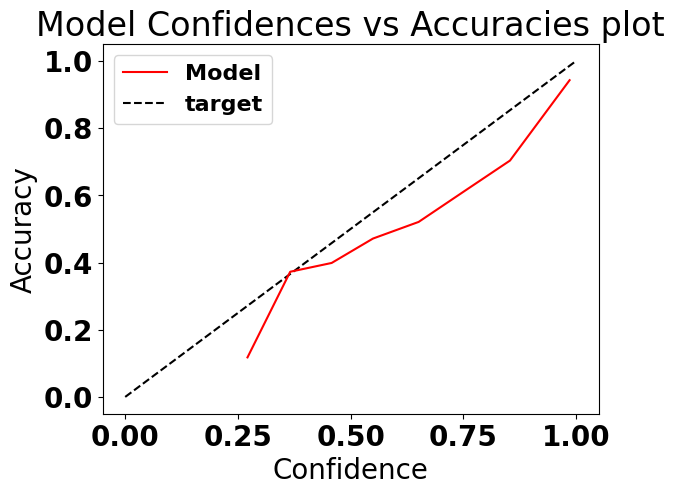

In [49]:
NumBins = 10
acc_for_each_Bm, conf_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds, Y_test2)[0:2]
    
#Remove NaN values
acc_Bm_no_NaN = [val for val in acc_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN = [val2 for val2 in conf_for_each_Bm if str(val2) != 'nan']

#Plot confidence of model vs accuracy of model
plt.plot(conf_Bm_no_NaN, acc_Bm_no_NaN,color = 'red')
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0) #[x0,x1], [y0,y1]
plt.title("Model Confidences vs Accuracies plot")
plt.legend(('Model','target'),loc=0, prop={'size': 16})
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

# Improving the Calibration
Now that we have a benchmark for the ECE on the test set, we will now improve the calibration by applying post processing techniques to the model predictions on the hold-out validation set. We then apply these rules to the test set.

# Method 1: Temperature Scaling
Temperature Scaling is one of the most effective calibration techniques in multi-class image classification and in neural networks. The following applies temperature scaling to improve the models calibration

## Create an NLL calculation function
To use temperature scaling, we first need to defined the negative log likelihood, or cross entropy loss.

In [50]:
def calculateNLL(X, Y, calibratedprobs = -999):
    """
    This function calculates the NLL on data provided.
    """

    if type(calibratedprobs) == type(np.array([0])):
        modelPredictX = calibratedprobs        
    else:
        modelPredictX = model.predict(X[0:])
        
    predictions_probs_arrays = modelPredictX

    #We need the confidence/prediction prob on the correct label
    #print(predictions_probs_arrays)
    
    prediction_prob_of_correct = predictions_probs_arrays[np.arange(len(Y)), Y.reshape((1,-1))[0]] # Take the prediction prob of the correct label for each
    log_prediction_prob_of_correct = np.log(prediction_prob_of_correct)
    NLL = -sum(log_prediction_prob_of_correct)

    return NLL


#a = calculateNLL(X_train, Y_train2)
#a1dot2 = calculateNLL(X_train[0:10000], Y_train2[0:10000])
#b = calculateNLL(X_validation, Y_validation)
#c = calculateNLL(X_test, Y_test2)
#print(a)
#print(a1dot2)
#print(b)
#print(c)


## Apply Temperature Scaling - CORRECT 
To calibrate the model, we will apply temperature scaling to ensure that the model confidences are approximately equal to the true likelihood that the predicted label is correct. To do this we will find the optimal value of T that minimizes the NLL on the validation set.

In [51]:
def temperature_scaling(logits, temperature):
    scaled_logits = logits / temperature
    calibrated_probs = tf.nn.softmax(scaled_logits).numpy()
    return calibrated_probs


logits = np.log(X_validation_preds)    #Define outside function
NLLmin = 9999999999999999999999
correspondingT = -99997

# Compute NLL on validation set using T temperature scaling
def compute_min_NLL(T):
    """ T is the temperature """
    global NLLmin   # Keep track of the minimum NLL
    global correspondingT # Keep track of the optimal T

    # Calculate calibrated probs that minimize the NLL
    calibrated_probs_x_validation = temperature_scaling(logits, T)

    # Compute NLL on updated calibrated probs
    NLL_update = calculateNLL("tempvalx", Y_validation2, calibrated_probs_x_validation)

    # Update the minimum NLL and optimal T if necessary
    if NLL_update < NLLmin:  #Lower NLL better
        NLLmin = NLL_update
        correspondingT = T
        print("NLL on validation set for T = ", T, " is:", NLL_update)
    return NLL_update

# Find optimal T by Minimising the NLL
from scipy.optimize import minimize
minimize(compute_min_NLL, 1)


# Update the probabilities of the model predictions for the test set to the calibrated temperature scaled model predictions
logits_x_test = np.log(X_test_preds)
X_test_preds_TS = temperature_scaling(logits_x_test, correspondingT)



# Check to see if this decreases the miscalibration on the test set
print("On the Validation set: Optimal T is", correspondingT, "And using this T value to calculate the ECE (10bins) on the test set gives: ", calculateECE(10, X_test_preds_TS, Y_test2))

# Compare with non calibrated original ECE
print("Remember that the ECE (10bins) using the standard T=1 (uncalibrated) was", calculateECE(10, X_test_preds, Y_test2))


NLL on validation set for T =  [1.]  is: 5339.838857977259
NLL on validation set for T =  [1.00000001]  is: 5339.838821306366
NLL on validation set for T =  [2.01]  is: 5218.519675752968
NLL on validation set for T =  [1.79831058]  is: 5007.75795485731
NLL on validation set for T =  [1.29326667]  is: 4914.005968767626
NLL on validation set for T =  [1.29326668]  is: 4914.005959101387
NLL on validation set for T =  [1.51698266]  is: 4864.642690557685
NLL on validation set for T =  [1.47423172]  is: 4860.8280248381025
NLL on validation set for T =  [1.46642897]  is: 4860.739577986064
NLL on validation set for T =  [1.46642898]  is: 4860.73957797062
NLL on validation set for T =  [1.46675652]  is: 4860.73940925275
NLL on validation set for T =  [1.46675405]  is: 4860.739409246723
NLL on validation set for T =  [1.46675405]  is: 4860.73940924672
NLL on validation set for T =  [1.46675406]  is: 4860.73940924671
On the Validation set: Optimal T is [1.46675406] And using this T value to calcu

/tmp/ipykernel_31/3890787813.py:7: RuntimeWarning: divide by zero encountered in log
  logits = np.log(X_validation_preds)    #Define outside function
/tmp/ipykernel_31/3890787813.py:36: RuntimeWarning: divide by zero encountered in log
  logits_x_test = np.log(X_test_preds)
/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_m

## Retest the Accuracy vs Confidence plot on the TS calibrated predictions
Same as before but now we can use the temperature scaled predictions

/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)


Text(0, 0.5, 'Accuracy')

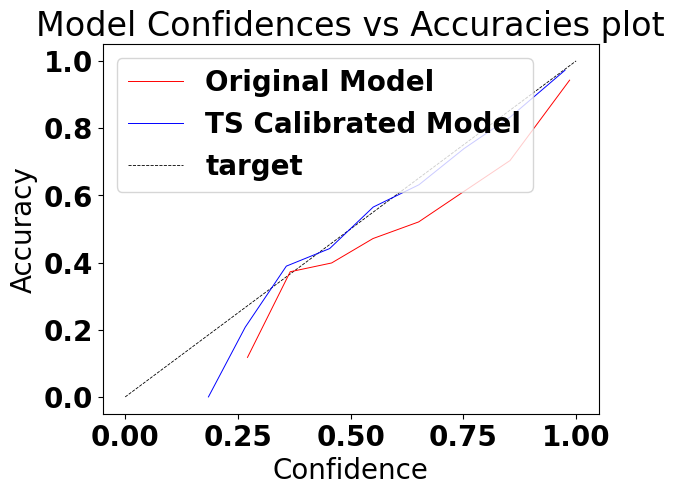

In [52]:
# Calculating values for the plot
# We will split into 10 equal width bins
NumBins = 10

#1
acc_for_each_Bm, conf_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds, Y_test2)[0:2]
    
# Remove NaN values
acc_Bm_no_NaN1 = [val for val in acc_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN1 = [val2 for val2 in conf_for_each_Bm if str(val2) != 'nan']


#2
acc_for_each_Bm_TS, conf_for_each_Bm_TS = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds_TS, Y_test2)[0:2]

# Remove NaN values
acc_Bm_no_NaN_TS = [val for val in acc_for_each_Bm_TS if str(val) != 'nan']
conf_Bm_no_NaN_TS = [val2 for val2 in conf_for_each_Bm_TS if str(val2) != 'nan']



# Plot confidence of model predictions vs accuracy of model
plt.plot(conf_Bm_no_NaN1, acc_Bm_no_NaN1, color = 'red', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_TS, acc_Bm_no_NaN_TS, color = 'blue', linewidth = 0.7)
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0, linewidth = 0.6) #[x0,x1], [y0,y1]

# Label the plot
plt.title("Model Confidences vs Accuracies plot")
plt.legend(('Original Model', 'TS Calibrated Model', 'target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

# Method 2: Isotonic Regression
Isotonic regression is another post processing technique used to calibrate model predictions. It use the validation set to fit an isotonic regression model. The method below uses a KvsRest isotonic regression fit, and K isotonic regression are fit. The probabilities are then combined and then renormalised to sum to 1. 

## Isotonic Regression

In [53]:
# Extract confidences for the each class
numclasses = num_classes

# Find indices separated for each class 
y_val_indexes = [ [] for k in range(0,numclasses,1) ]
for i in range(0,len(Y_validation2),1):
    y_val_indexes[Y_validation2[i][0]].append(i)


# For each class, state the confidence of the model (for that class) for every validation sample                   
model_preds_organised = [ [X_validation_preds[:,i]] for i in range(0,numclasses,1) ]
model_preds_organised = np.asarray(model_preds_organised)


# For isotonic regression, need a 1 when the sample belongs to that class, and 0 otherwise
y_true_organised = [ np.zeros(len(Y_validation2)) for i in range(0,numclasses,1) ]
for i in range(0,numclasses,1):
    (y_true_organised[i])[y_val_indexes[i]] = 1




# For each class, state the confidence of the model (for that class) for every test sample
# These are the prediction probs we wish to calibrate
model_test_preds_organised = [ [X_test_preds[:,i]] for i in range(0,numclasses,1) ]
model_test_preds_organised = np.asarray(model_test_preds_organised)



#Isotonic regression for each class k in a kvsrest array
isotonic_probs_array = [ [] for k in range(0,numclasses,1) ]



# Import
from sklearn.calibration import IsotonicRegression


# For each class K
for i in range(0, numclasses, 1):
    
    # Fit Isotonic regression on the validation set for class k
    isotonic1 = IsotonicRegression(out_of_bounds='clip',
                                   y_min=model_preds_organised[i][0].min(),
                                   y_max=model_preds_organised[i][0].max())
    
    isotonic1.fit(model_preds_organised[i][0], np.reshape(y_true_organised[i], (-1)))

    # Apply this Isotonic regression to the test set for that k class
    isotonic_probs_array[i] = isotonic1.predict(model_test_preds_organised[i][0])

isotonic_probs_array = np.asarray(isotonic_probs_array)


# Reformat the Isotonic predictions into similar format to X_test_preds
class_non_normalized_confidences_array = np.transpose(isotonic_probs_array)

# Now normalise each row
row_sums = class_non_normalized_confidences_array.sum(axis=1)
X_test_preds_Isotonic = class_non_normalized_confidences_array / row_sums[:, np.newaxis]

# Compute max probabilites for each test sample
X_test_Isotonic_predicted_labels = X_test_preds_Isotonic.argmax(axis=1)
X_test_Isotonic_accuracy = (sum(Y_test2.reshape(-1,) == X_test_Isotonic_predicted_labels)) / (len(Y_test2))

# Check results
print("Post-Processing Isotonic Regression ECE (10 bins): ", calculateECE(10, X_test_preds_Isotonic, Y_test2))
print("Recall the ECE (10 bins) on the original non calibrated model was: ", calculateECE(10, X_test_preds, Y_test2))

# Isotonic regression predictions may have a new accuracy 
print("----------------------------------------------------------")
print("Isotonic regression calibrated accuracy: ", X_test_Isotonic_accuracy)
print("Recall original model accuracy: ", accuracy)


Post-Processing Isotonic Regression ECE (10 bins):  0.01149491055905821
Recall the ECE (10 bins) on the original non calibrated model was:  0.0649685393035412
----------------------------------------------------------
Isotonic regression calibrated accuracy:  0.8344
Recall original model accuracy:  0.8325999975204468


/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


## Isotonic regression plots
For further understanding, we show the k confidence to score plots. In other words, if a test sample 1 has a confidence 0.8 for class 1, we will change this confidence to the associated score in the isotonic regression. We update confidence for all classes for each test sample. The plots below are these plots.

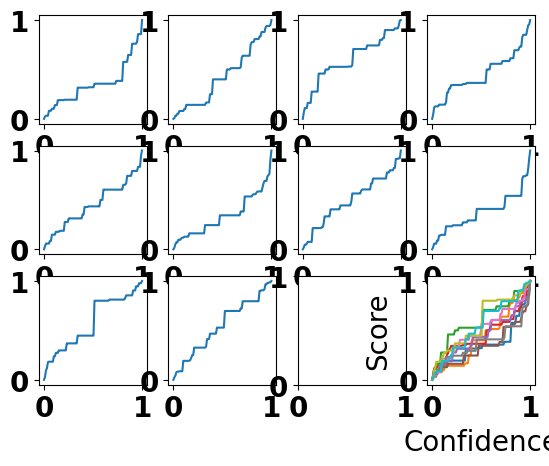

In [54]:
fig, ax = plt.subplots(3, 4)

# 10 individual subplots and one of first 10 classes

# For first 10 classes:
for i in range(0, numclasses, 1):
    
    # Fit Isotonic regression on the validation set for class k
    isotonic1 = IsotonicRegression(out_of_bounds='clip',
                                   y_min=model_preds_organised[i][0].min(),
                                   y_max=model_preds_organised[i][0].max())
    
    isotonic1.fit(model_preds_organised[i][0], np.reshape(y_true_organised[i], (-1)))
    
   
    # Show how confidences would be updated for class k on single plot
    Updated_scores_k = isotonic1.predict(np.linspace(0,1, 100))
    ax[(i//4), i%4].plot( np.linspace(0,1, 100), Updated_scores_k, "-" )

    # Add to the same subplot
    ax[2, 3].plot(np.linspace(0,1, 100), Updated_scores_k, "-")


plt.xlabel("Confidence")
plt.ylabel("Score")

plt.show()


# Monotonic non-decreasing, all isotonic fits, would be like this, show all of them!

## Retest the Accuracy vs Confidence plot on the Isotonic calibrated predictions
Same as before but now we can use the Isotonic calibrated confidences predictions

/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Accuracy')

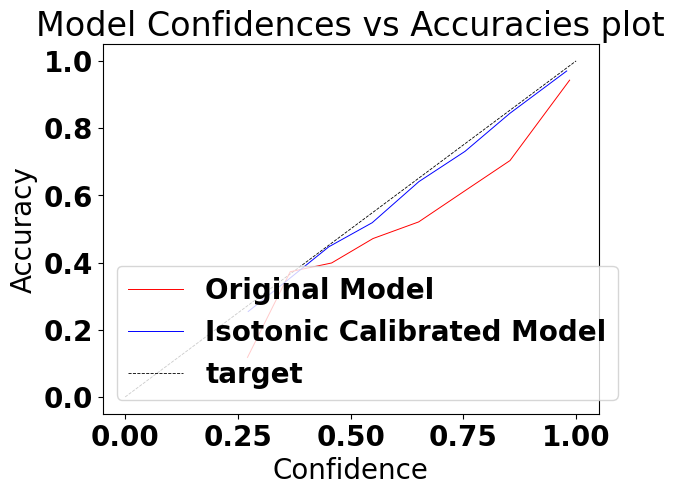

In [55]:
# Calculating values for the plot
# We will split into 10 equal width bins
NumBins = 10

#1
acc_for_each_Bm, conf_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds, Y_test2)[0:2]
    
# Remove NaN values
acc_Bm_no_NaN1 = [val for val in acc_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN1 = [val2 for val2 in conf_for_each_Bm if str(val2) != 'nan']


#2
acc_for_each_Bm_Isotonic, conf_for_each_Bm_Isotonic = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds_Isotonic, Y_test2)[0:2]

# Remove NaN values
acc_Bm_no_NaN_Isotonic = [val for val in acc_for_each_Bm_Isotonic if str(val) != 'nan']
conf_Bm_no_NaN_Isotonic = [val2 for val2 in conf_for_each_Bm_Isotonic if str(val2) != 'nan']



# Plot confidence of model predictions vs accuracy of model
plt.plot(conf_Bm_no_NaN1, acc_Bm_no_NaN1, color = 'red', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_Isotonic, acc_Bm_no_NaN_Isotonic, color = 'blue', linewidth = 0.7)
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0, linewidth = 0.6) #[x0,x1], [y0,y1]

# Label the plot
plt.title("Model Confidences vs Accuracies plot")
plt.legend(('Original Model', 'Isotonic Calibrated Model', 'target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

# Method 3: Inductive Venn Abers Predictors
The third method again uses the model prediction confidences to apply the post processing calibration technique Inductive Venn Abers Predictors (IVAP), which includes using many isotonic regressions. For a specified class IVAP fits isotonic regression to both validation set + 1 test example, once where test example label is 0 and then once where it is 1. We will use this to find lower and upper confidences p_0 and p_1 for that test example for that class. We then repeat this for all classes and for all test examples. Next we apply the formula p = p1 / (1-p0+p1) as the updated confidence for each test example for each class. Finally we combine the k classes by ensuring they sum to one.

## Inductive Venn Abers Predictors
Split into k KvsRest binary classifications. Fit isotonic regression to validation set and test example labeled 0 for that class to find p0. Fit isotonic regression to validation set and test example labeled 1 for that class to find p1. We will begin with binary classification and find p_0 and p_1 in one KvsRest case. We will do this for all the test examples.

In [56]:
numclasses = num_classes

# Create lists that will store all p0 (and p1) values for each test example, for every class
p0_biglist=[[] for k in range(0,numclasses,1)]
p1_biglist=[[] for k in range(0,numclasses,1)]

counter = 0

# For each class k
for k in range(0,numclasses,1):
    
    p0_list=[]   # lower probs of class k for all test examples
    p1_list=[]   # upper probs of class k for all test examples

    
    
    # We will need the true validation labels combined with the assumed test example label:
    
    # Get indices of validation samples that belong to kth class
    y_val_classk_indices = np.where(Y_validation2.reshape(1,-1)[0] == (np.zeros(len(Y_validation2)) + k))

    # Put 1 in validation samples that belong to kth class and 0 in validation samples that do not belong to the kth class
    y_val_class_k_or_not = np.zeros(len(Y_validation2))
    y_val_class_k_or_not[y_val_classk_indices] = 1

    # Create two arrays, one where we assume the test example does not belong to class k (label 0) and
    # another where we assume the test example belongs to class k (label 1)
    y_val_class_k_or_not_with_0_example = np.concatenate((y_val_class_k_or_not, np.array([0])))
    y_val_class_k_or_not_with_1_example = np.concatenate((y_val_class_k_or_not, np.array([1])))



    # Now we will need the validation confidence for class k which we will need to combine with a test example confidence for class k
    model_preds_without_example_class_k = X_validation_preds[:,k]
    
    # For each test example
    for i in range(0,len(X_test_preds),1):

        # Get confidences of one test example
        conf_one_test_example = X_test_preds[i]       

        # Combine validation confidences for class k with the test example confidence for class k
        model_preds_with_example_classk = np.concatenate((model_preds_without_example_class_k, np.array( [conf_one_test_example[k]] )), axis=0)
        


        
        # In IVAP fit Isotonic regression to (validation + 1 test example) confidences and associated labels for the (validation + 1 test example)
        # Lower isotonic regression uses test example as label 0, and Upper isotonic regression uses test example as label 1:
    
        #1: Lower Isotonic regression to find p0
        isotonic_l = IsotonicRegression(out_of_bounds='clip',
                                  y_min=model_preds_with_example_classk.min(), #check
                                  y_max=model_preds_with_example_classk.max())
        isotonic_l.fit(model_preds_with_example_classk, y_val_class_k_or_not_with_0_example)

        # Compute lower confidence for this test example for class k
        isotonic_prob_p0 = isotonic_l.predict( np.array([conf_one_test_example[k]]) )

        
        #2 Upper Isotonic regression to find p1
        isotonic_u = IsotonicRegression(out_of_bounds='clip',
                                  y_min=model_preds_with_example_classk.min(), #check
                                  y_max=model_preds_with_example_classk.max())
        isotonic_u.fit(model_preds_with_example_classk, y_val_class_k_or_not_with_1_example)

        # Compute upper confidence for this test example for class k    
        isotonic_prob_p1 = isotonic_u.predict( np.array([conf_one_test_example[k]]) )

    
        #Results for one test example for class k:
        p0_list.append(isotonic_prob_p0[0])
        p1_list.append(isotonic_prob_p1[0])

        
        counter = counter+1

    print("Class ", k+1, "/", numclasses, "complete. Running total of Isotonic regressions: 2 x", counter)

    # Update big lists with all p0 (and p1) values for each test example for class k
    p0_biglist[k] = p0_list
    p1_biglist[k] = p1_list



print("All isotonic regressions have been ran.")
print("----------------")






# Loading Results:

# Convert to array
p0_bigarray = np.asarray(p0_biglist)
p1_bigarray = np.asarray(p1_biglist)

# Extract p's using formula p = p1 / (1-p0+p1)
p = p1_bigarray / (1-p0_bigarray+p1_bigarray)

# Reformat into consistent form
IVAP_Predict_X_test_non_nomralized = np.transpose(p)

# Normalize
row_sums2 = np.sum(IVAP_Predict_X_test_non_nomralized, axis=1)
X_test_preds_IVAP = IVAP_Predict_X_test_non_nomralized / row_sums2[:, np.newaxis]

# Compute max probabilites for each test sample
X_test_IVAP_predicted_labels = X_test_preds_IVAP.argmax(axis=1)
X_test_IVAP_accuracy = (sum(Y_test2.reshape(-1,) == X_test_IVAP_predicted_labels)) / (len(Y_test2))



# Check Results
print("IVAP ECE: ", calculateECE(10, X_test_preds_IVAP, Y_test2))
print("Recall the ECE (10 bins) on the original non calibrated model was: ", calculateECE(10, X_test_preds, Y_test2))

# IVAP predictions may have a new accuracy
print("IVAP calibrated accuracy: ", X_test_IVAP_accuracy) # improved by +1
print("Recall original model accuracy: ", accuracy)



#For the whole k=10 classes for all p_0 and p_1 (two for loops and a total of 200,000 isotonic regressions):
#Start: 15:05:30
#End: 15:13:10 - - 7mins 40s


Class  1 / 10 complete. Running total of Isotonic regressions: 2 x 10000
Class  2 / 10 complete. Running total of Isotonic regressions: 2 x 20000
Class  3 / 10 complete. Running total of Isotonic regressions: 2 x 30000
Class  4 / 10 complete. Running total of Isotonic regressions: 2 x 40000
Class  5 / 10 complete. Running total of Isotonic regressions: 2 x 50000
Class  6 / 10 complete. Running total of Isotonic regressions: 2 x 60000
Class  7 / 10 complete. Running total of Isotonic regressions: 2 x 70000
Class  8 / 10 complete. Running total of Isotonic regressions: 2 x 80000
Class  9 / 10 complete. Running total of Isotonic regressions: 2 x 90000
Class  10 / 10 complete. Running total of Isotonic regressions: 2 x 100000
All isotonic regressions have been ran.
----------------
IVAP ECE:  0.00268738992810251
Recall the ECE (10 bins) on the original non calibrated model was:  0.0649685393035412
IVAP calibrated accuracy:  0.8341
Recall original model accuracy:  0.8325999975204468


/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


# IVAP details
To further understand IVAP, we check some of the details.

Average interval width of (p0, p1):  0.003983469
Maximum interval width of (p0, p1):  0.30555558
Therefore, the model has the highest interval width (p0, p1) in class  8 , at test example  6486
--------------------------------------------------
Further evaluating the maximum interval width ( Test  6486  and class  8 ) for better understanding:
Original confidence:  0.50982445
( p0 , p1 ) = ( 0.5 , 0.8055556 ) - Note that this is not normalised, but gives a rough idea of the interval width


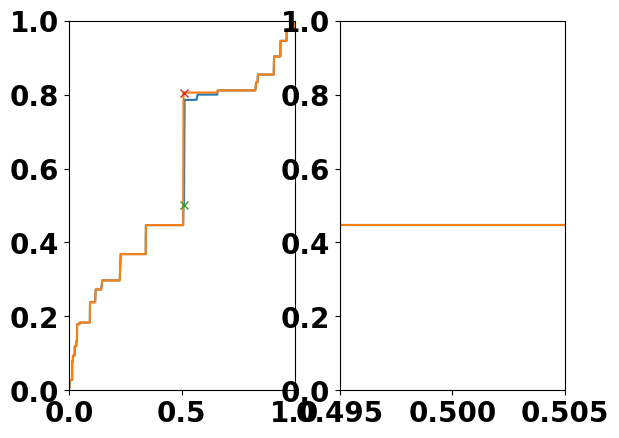

In [57]:
np.set_printoptions(suppress=True)

# The bigger the interval width of (p0, p1) means the more unsure the model is for that prediction.
# Let's check the average and maximum interval width
print("Average interval width of (p0, p1): ", (p1_bigarray-p0_bigarray).mean())
print("Maximum interval width of (p0, p1): ", (p1_bigarray-p0_bigarray).max())



# Extract maximum interval width
index_max_p0_p1_width = (p1_bigarray-p0_bigarray).argmax()
max_p0_p1_width_class, index_max_p0_p1_width_test_example = [index_max_p0_p1_width // len(Y_test2), index_max_p0_p1_width % len(Y_test2)]
print("Therefore, the model has the highest interval width (p0, p1) in class ", max_p0_p1_width_class, ", at test example ", index_max_p0_p1_width_test_example)



# Let's Repeat the IVAP process for this specific class and for this specific test example:
M = max_p0_p1_width_class
T = index_max_p0_p1_width_test_example


# Get indices of validation samples that belong to class M
y_val_classM_indices = np.where(Y_validation2.reshape(1,-1)[0] == (np.zeros(len(Y_validation2)) + M))

# Put 1 in validation samples that belong to class M and 0 in validation samples that do not belong to the class M
y_val_class_M_or_not = np.zeros(len(Y_validation2))
y_val_class_M_or_not[y_val_classM_indices] = 1

# Create two arrays, one where we assume the test example T does not belong to class M and one where we assume the test example does belong to class M
y_val_class_M_or_not_with_0_example = np.concatenate((y_val_class_M_or_not, np.array([0])))
y_val_class_M_or_not_with_1_example = np.concatenate((y_val_class_M_or_not, np.array([1])))

# Now we will need the validation confidence for class M which we will need to combine with a test example T confidence for class M
model_preds_without_example_class_M = X_validation_preds[:,M]

# Get confidences of test example T
conf_one_test_example_T = X_test_preds[T]       

# Combine validation confidences for class M with the test example T confidence for class M
model_preds_with_example_classM = np.concatenate((model_preds_without_example_class_M, np.array( [conf_one_test_example_T[M]] )), axis=0)


#1: Fit Lower Isotonic regression to find p0 for Test example T for class M
isotonic_l = IsotonicRegression(out_of_bounds='clip',
                          y_min=model_preds_with_example_classM.min(), #check
                          y_max=model_preds_with_example_classM.max())
isotonic_l.fit(model_preds_with_example_classM, y_val_class_M_or_not_with_0_example)

# Compute lower confidence for this test example for class k
p0_testT_classM = isotonic_l.predict( np.array([conf_one_test_example_T[M]]) )[0]


#2 Upper Isotonic regression to find p1
isotonic_u = IsotonicRegression(out_of_bounds='clip',
                          y_min=model_preds_with_example_classM.min(), #check
                          y_max=model_preds_with_example_classM.max())
isotonic_u.fit(model_preds_with_example_classM, y_val_class_M_or_not_with_1_example)

# Compute upper confidence for this test example for class k    
p1_testT_classM = isotonic_u.predict( np.array([conf_one_test_example_T[M]]) )[0]

print("--------------------------------------------------")




# Now check results:
print("Further evaluating the maximum interval width ( Test ", T, " and class ", M,") for better understanding:")
print("Original confidence: ", conf_one_test_example_T[M] )
print("( p0 , p1 ) = (", p0_testT_classM, ",", p1_testT_classM, ") - Note that this is not normalised, but gives a rough idea of the interval width")

# Plot lower score function and upper score function
x_inputs = np.linspace(0,1,10000)

fig, ax = plt.subplots(1, 2)

# Plot lower and upper bounds
ax[0].axis([0.0, 1.0, 0.0, 1.0])
ax[0].plot(x_inputs, isotonic_l.predict(x_inputs))
ax[0].plot(x_inputs, isotonic_u.predict(x_inputs))
ax[0].plot(conf_one_test_example_T[M], p0_testT_classM, 'x') # Demonstrate how IVAP updated the confidence, lower bound
ax[0].plot(conf_one_test_example_T[M], p1_testT_classM, 'x') # Demonstrate how IVAP updated the confidence, upper bound


# Replot lower and upper bounds but zoom in
import math
x_min_zoom = math.floor(conf_one_test_example_T[M] * 100)/100.0 - 0.005
x_max_zoom = math.floor(conf_one_test_example_T[M] * 100)/100.0 + 0.005

ax[1].axis([x_min_zoom, x_max_zoom, 0, 1])
ax[1].plot(x_inputs, isotonic_l.predict(x_inputs))
ax[1].plot(x_inputs, isotonic_u.predict(x_inputs))
ax[1].plot(conf_one_test_example_T[M], p0_testT_classM, 'x') # Demonstrate how IVAP updated the confidence, lower bound
ax[1].plot(conf_one_test_example_T[M], p1_testT_classM, 'x') # Demonstrate how IVAP updated the confidence, upper bound

# In the binary classification sense, the orange line represents the upper confidence and the blue line represents the lower confidence. 
# This gives an interval for the updated confidence, where the true confidence should lie within this interval.
# However, in multiclass classification these confidences need to be normalised.

# The green cross is p0 for test example T for class M, the red cross is p1 for test example T for class M

## Show a plot of p0 and p1 for each test example for a specific class

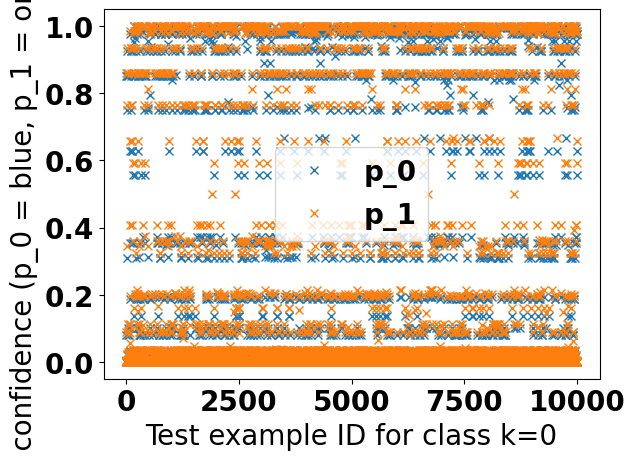

In [58]:
# A plot of p_0 vs p_1 for class k
k = 0

p0_list_classk = p0_bigarray[k]
p1_list_classk = p1_bigarray[k]

x = range(0, len(p0_list_classk), 1)
plt.plot(x, p0_list_classk, 'x')
plt.plot(x, p1_list_classk, 'x')
plt.legend(('p_0', 'p_1'), loc=0)

xlabel = "Test example ID for class k=" + str(k)
plt.xlabel(xlabel)
plt.ylabel("p confidence (p_0 = blue, p_1 = orange)")
plt.show()

## Show a plot of p0 and p1 for each test example for every class

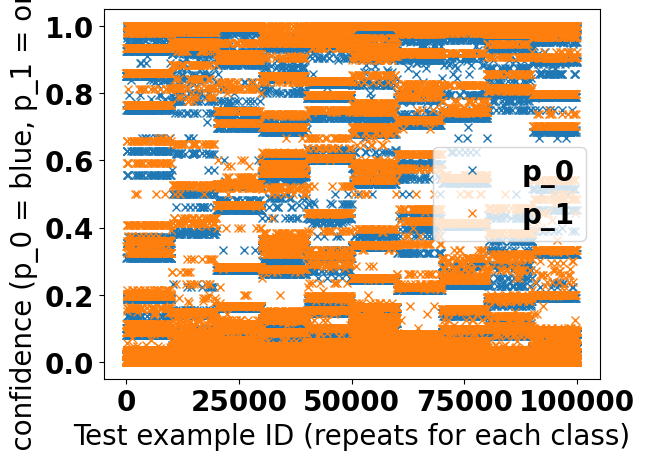

In [59]:
# A plot of p_0 vs p_1 for each class
x = range(0,len(p0_bigarray.reshape(1,-1)[0]))
plt.plot(x, p0_bigarray.reshape(1,-1)[0], 'x')
plt.plot(x, p1_bigarray.reshape(1,-1)[0], 'x')
plt.legend(('p_0', 'p_1'), loc=0)
plt.xlabel("Test example ID (repeats for each class)")
plt.ylabel("p confidence (p_0 = blue, p_1 = orange)")
plt.show()

# The pattern changes for each class

## Retest the Accuracy vs Confidence plot on the IVAP calibrated predictions
Same as before but now we can use the IVAP calibrated predictions

/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Accuracy')

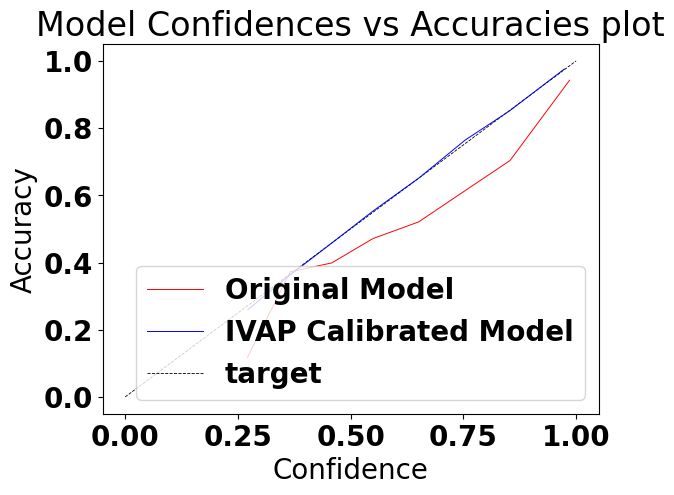

In [60]:
# Calculating values for the plot
# We will split into 10 equal width bins
NumBins = 10

#1
acc_for_each_Bm, conf_for_each_Bm = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds, Y_test2)[0:2]
    
# Remove NaN values
acc_Bm_no_NaN1 = [val for val in acc_for_each_Bm if str(val) != 'nan']
conf_Bm_no_NaN1 = [val2 for val2 in conf_for_each_Bm if str(val2) != 'nan']


#2
acc_for_each_Bm_IVAP, conf_for_each_Bm_IVAP = calculate_Acc_Conf_for_each_Bm(NumBins, X_test_preds_IVAP, Y_test2)[0:2]

# Remove NaN values
acc_Bm_no_NaN_IVAP = [val for val in acc_for_each_Bm_IVAP if str(val) != 'nan']
conf_Bm_no_NaN_IVAP = [val2 for val2 in conf_for_each_Bm_IVAP if str(val2) != 'nan']


# Plot confidence of model predictions vs accuracy of model
plt.plot(conf_Bm_no_NaN1, acc_Bm_no_NaN1, color = 'red', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_IVAP, acc_Bm_no_NaN_IVAP, color = 'blue', linewidth = 0.7)
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0, linewidth = 0.6) #[x0,x1], [y0,y1]

# Label the plot
plt.title("Model Confidences vs Accuracies plot")
plt.legend(('Original Model', 'IVAP Calibrated Model', 'target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

# Comparing the three post-processing calibration methods
Temperature scaling is extremely efficient and typically performs best for neural networks. Isotonic regression also can be performed quickly, and can work great when there is lots of data or the data is complex. IVAP typically produces better results than Isotonic regression, however IVAP is very computationally expensive.

## Compare the Accuracy vs Confidence plot on the three calibrated TS, Isotonic, and IVAP predictions
Finally, we show the accuracy vs confidence plots for the three post-processing calibration methods. We also compare the ECEs and accuracies of the non-calibrated, Temperature scaled, Isotonic, and IVAP predictions

ECEs:
Original model/Uncalibrated:  0.0649685393035412
TS:  0.009737072325629419
Isotonic:  0.01149491055905821
IVAP:  0.00268738992810251
------------------------------------------------------
Accuracies:
Original model/Uncalibrated:  0.8325999975204468
TS:  0.8325999975204468
Isotonic:  0.8344
IVAP:  0.8341


/tmp/ipykernel_31/2310172033.py:19: RuntimeWarning: Mean of empty slice.
  accuracy_for_each_Bm = [label_type_for_each_Bm[count].mean() for count in range(0,NumBins,1)]                  #Accuracy for each confidence Bm interval - acc(Bm)
/tmp/ipykernel_31/2310172033.py:20: RuntimeWarning: Mean of empty slice.
  confidence_for_each_Bm = [prediction_prob_of_max[indices_for_each_Bm[count]].mean() for count in range(0,NumBins,1)]                  # Avg confidence for each Bm confidence interval - conf(Bm)


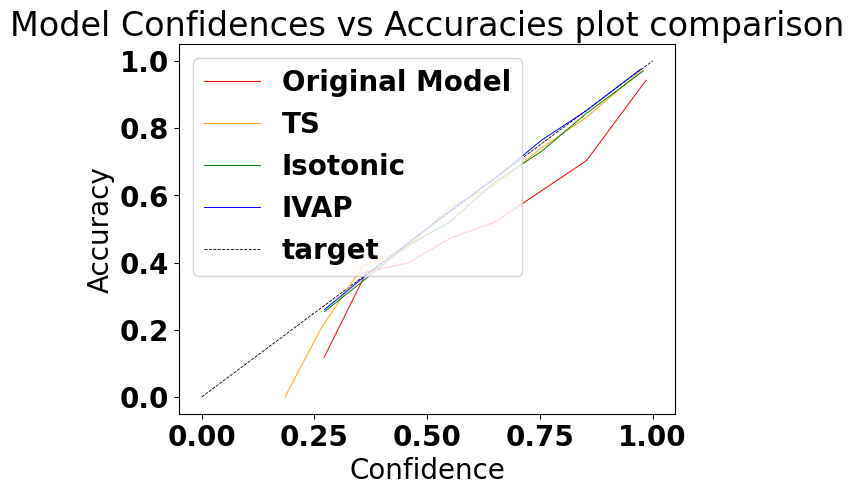

In [61]:
# Split into 10 equal width bins
NumBins = 10

# Plot confidence of model predictions vs accuracy of model
plt.plot(conf_Bm_no_NaN1, acc_Bm_no_NaN1, color = 'red', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_TS, acc_Bm_no_NaN_TS, color = 'orange', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_Isotonic, acc_Bm_no_NaN_Isotonic, color = 'green', linewidth = 0.7)
plt.plot(conf_Bm_no_NaN_IVAP, acc_Bm_no_NaN_IVAP, color = 'blue', linewidth = 0.7)
plt.plot([0,1], [0,1], color ='black', linestyle = '--', zorder = 0, linewidth = 0.6) #[x0,x1], [y0,y1]

# Label the plot
plt.title("Model Confidences vs Accuracies plot comparison")
plt.legend(('Original Model', 'TS', 'Isotonic', 'IVAP', 'target'),loc=0)
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

print("ECEs:")
print("Original model/Uncalibrated: ", calculateECE(NumBins, X_test_preds, Y_test2))
print("TS: ", calculateECE(NumBins, X_test_preds_TS, Y_test2))
print("Isotonic: ", calculateECE(NumBins, X_test_preds_Isotonic, Y_test2))
print("IVAP: ", calculateECE(NumBins, X_test_preds_IVAP, Y_test2))

print("------------------------------------------------------")

print("Accuracies:")
print("Original model/Uncalibrated: ", accuracy)
print("TS: ", accuracy)   # Note that temperature scaling does not affect the accuracy
print("Isotonic: ", X_test_Isotonic_accuracy)
print("IVAP: ", X_test_IVAP_accuracy)